In [1]:
K = 15
P = "JAHELKA"
L = nchar(P)
M = ((K+L)*47)%%11 + 1
M

[1] 1

Vybraný reprezentant je Lukáš Jahelka.
Budeme tedy pracovat s datasetem číslo <b>1.</b>

![NUTS3](nuts3.png)

In [2]:
library(eurostat)
library(ggplot2)
library(corrplot)
library(vtable)
library(cowplot)
library(moments)
library(e1071)

corrplot 0.92 loaded

Loading required package: kableExtra


Attaching package: ‘e1071’


The following objects are masked from ‘package:moments’:

    kurtosis, moment, skewness




<h3><u>Úloha 1</u></h3>
Proveďte základní statistická šetření:

* Zkoumaná data stručně popište.
* Určete nejdůležitější statistické míry, které data nejlépe charakterizují.
* Vhodně data reprezentujte pomocí vybraných grafů.

In [3]:
search_eurostat(pattern='Population on 1 January by broad age group, sex and NUTS 3 region')

title,code,type,last update of data,last table structure change,data start,data end,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
"Population on 1 January by broad age group, sex and NUTS 3 region",demo_r_pjanaggr3,dataset,31.03.2023,30.03.2023,1990,2022,NA
"Population on 1 January by broad age group, sex and NUTS 3 region",demo_r_pjanaggr3,dataset,31.03.2023,30.03.2023,1990,2022,NA


In [4]:
id <- "demo_r_pjanaggr3"
data_copy <- get_eurostat(id=id)

In [5]:
head(data_copy)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,AT,2022-01-01,4553444
NR,F,TOTAL,AT1,2022-01-01,2000081
NR,F,TOTAL,AT11,2022-01-01,151557
NR,F,TOTAL,AT111,2022-01-01,19074
NR,F,TOTAL,AT112,2022-01-01,83093
NR,F,TOTAL,AT113,2022-01-01,49390


<b>Příprava dat</b>

Nejprve si vybereme regiony České republiky. Dataset dále vyfiltrujeme na údaje, které se vážou k roku 2021.

In [6]:
regiony <- c("CZ010", "CZ020", "CZ031", "CZ032", "CZ041", "CZ042", "CZ051", "CZ052", "CZ053", "CZ063", "CZ064", "CZ071", "CZ072", "CZ080")

In [7]:
data <- data_copy[data_copy$geo %in% regiony,]
data <- data[data$time == "2021-01-01",]

<b>Vysvětlení příznaků</b>

* unit - jednotka měření
* sex - pohlaví
* age - věková kategorie
* geo - jednotlivé regiony
* time - čas měření
* values - počet obyvatel pro region

Počet sloupců v naší databázi je 6.
Počet záznámů je 210.

In [8]:
dim(data)

[1] 210   6

In [9]:
sum(is.na(data))

[1] 0

Vidíme, že tabulka neobsahuje žádné chybějící hodnoty, tudíž můžeme pokračovat. Z dat nejdříve vyhodíme řádky obsahující hodnotu "UNK" u sloupečku <b>age</b>, jelikož tyto řádky neobsahují pro naši práci důležitou informaci.

In [10]:
data <- subset(data, age!="UNK")
head(data)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,CZ010,2021-01-01,681430
NR,F,TOTAL,CZ020,2021-01-01,706011
NR,F,TOTAL,CZ031,2021-01-01,325503
NR,F,TOTAL,CZ032,2021-01-01,297223
NR,F,TOTAL,CZ041,2021-01-01,148298
NR,F,TOTAL,CZ042,2021-01-01,411727


Nastavíme diskrétní hodnoty na factor a rozdělíme si tabulku na muže a ženy.

In [11]:
data$sex <- as.factor(data$sex)
data$age <- as.factor(data$age)
summary(data)

     unit           sex        age         geo                 time           
 Length:168         F:56   TOTAL :42   Length:168         Min.   :2021-01-01  
 Class :character   M:56   Y_GE65:42   Class :character   1st Qu.:2021-01-01  
 Mode  :character   T:56   Y_LT15:42   Mode  :character   Median :2021-01-01  
                           Y15-64:42                      Mean   :2021-01-01  
                                                          3rd Qu.:2021-01-01  
                                                          Max.   :2021-01-01  
     values       
 Min.   :  21680  
 1st Qu.:  79112  
 Median : 164966  
 Mean   : 254804  
 3rd Qu.: 327029  
 Max.   :1397997  

In [12]:
females <- subset(data, sex=="F", select=c("geo", "age", "values"))
colnames(females) <- c("geo", "age", "females")
males <- subset(data, sex=="M", select=c("geo", "age", "values"))
colnames(males) <- c("geo", "age", "males")

In [13]:
summary(females)

     geo                age        females      
 Length:56          TOTAL :14   Min.   : 21680  
 Class :character   Y_GE65:14   1st Qu.: 67546  
 Mode  :character   Y_LT15:14   Median :145987  
                    Y15-64:14   Mean   :193810  
                                3rd Qu.:267081  
                                Max.   :706011  

In [14]:
summary(males)

     geo                age         males       
 Length:56          TOTAL :14   Min.   : 22838  
 Class :character   Y_GE65:14   1st Qu.: 52264  
 Mode  :character   Y_LT15:14   Median :119707  
                    Y15-64:14   Mean   :188396  
                                3rd Qu.:269776  
                                Max.   :691986  

Po aplikaci funkce summary pro muže a ženy, kde zvažujeme všechny věkové kategorie se zdá, že jsou muži i ženy podobně rozprostřeni. Jednotlivé údaje jako minimum, maximum, průměr... se liší minimálně, v řádech tisíců. To by mělo odpovídat i měření v rámci "sčítání lidu" z roku 2021.

In [15]:
summary(females[females$age=="Y_GE65",])

     geo                age        females      
 Length:14          TOTAL : 0   Min.   : 34795  
 Class :character   Y_GE65:14   1st Qu.: 63397  
 Mode  :character   Y_LT15: 0   Median : 74083  
                    Y15-64: 0   Mean   : 89205  
                                3rd Qu.:129434  
                                Max.   :148431  

In [16]:
summary(males[males$age=="Y_GE65",])

     geo                age         males       
 Length:14          TOTAL : 0   Min.   : 25989  
 Class :character   Y_GE65:14   1st Qu.: 47066  
 Mode  :character   Y_LT15: 0   Median : 54068  
                    Y15-64: 0   Mean   : 64961  
                                3rd Qu.: 91783  
                                Max.   :111747  

Když se ale podíváme na obyvatele starší 65 let, tak nastávájí větší rozdíly mezi pohlavími. Například si můžeme všimnout výrazného rozdílu hodnot mediánů (ženy - 74083, muži - 54068). Díky tomu můžeme předpokládat, že ženy žijí déle jak muži. 

In [17]:
summary(females[females$age=="Y_LT15",])

     geo                age        females      
 Length:14          TOTAL : 0   Min.   : 21680  
 Class :character   Y_GE65: 0   1st Qu.: 41050  
 Mode  :character   Y_LT15:14   Median : 46876  
                    Y15-64: 0   Mean   : 59915  
                                3rd Qu.: 83128  
                                Max.   :121614  

In [18]:
summary(males[males$age=="Y_LT15",])

     geo                age         males       
 Length:14          TOTAL : 0   Min.   : 22838  
 Class :character   Y_GE65: 0   1st Qu.: 43194  
 Mode  :character   Y_LT15:14   Median : 48903  
                    Y15-64: 0   Mean   : 62924  
                                3rd Qu.: 87488  
                                Max.   :127667  

Pro zajímavost vypíšeme obyvatele mladší 15 let. Hodnoty statistických měr jsou opět vyrovnané.

In [19]:
print(var(females$females))

[1] 29102176444


In [20]:
print(var(males$males))

[1] 28951105294


Nakonec data ještě spojíme do jednoho výsledného dataframu.

In [21]:
df <- merge(females,males)
head(df)

,geo,age,females,males
,<chr>,<fct>,<dbl>,<dbl>
1,CZ010,TOTAL,681430,653654
2,CZ010,Y_GE65,148218,104893
3,CZ010,Y_LT15,103743,109081
4,CZ010,Y15-64,429469,439680
5,CZ020,TOTAL,706011,691986
6,CZ020,Y_GE65,148431,111747


<b>Zajímavé regiony</b>

In [22]:
dF <- df

In [23]:
dF$geo <- factor(dF$geo, levels = c("CZ010", "CZ020", "CZ031", "CZ032", "CZ041", "CZ042", "CZ051", "CZ052", "CZ053", "CZ063", "CZ064", "CZ071", "CZ072", "CZ080"), labels = c("Hlavní město Praha", "Středočeský kraj", "Jihočeský kraj", "Plzeňský kraj", "Karlovarský kraj", "Ústecký kraj", "Liberecký kraj","Královéhradecký kraj","Pardubický kraj","Kraj Vysočina","Jihomoravský kraj", "Olomoucký kraj","Zlínský kraj", "Moravskoslezský kraj"))

In [24]:
dF$Total_Population <- dF$males + dF$females
dF$Gender_Difference <- abs(dF$males - dF$females)
dF$Relative_Males <- dF$males / (dF$males + dF$females)
dF$Relative_Females <- dF$females / (dF$males + dF$females)
dF$Relative_Gender_Difference <- abs(dF$Relative_Males - dF$Relative_Females)
head(dF)

,geo,age,females,males,Total_Population,Gender_Difference,Relative_Males,Relative_Females,Relative_Gender_Difference
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Hlavní město Praha,TOTAL,681430,653654,1335084,27776,0.4895977,0.5104023,0.02080468
2,Hlavní město Praha,Y_GE65,148218,104893,253111,43325,0.4144150,0.5855850,0.17116996
3,Hlavní město Praha,Y_LT15,103743,109081,212824,5338,0.5125409,0.4874591,0.02508176
4,Hlavní město Praha,Y15-64,429469,439680,869149,10211,0.5058741,0.4941259,0.01174827
5,Středočeský kraj,TOTAL,706011,691986,1397997,14025,0.4949839,0.5050161,0.01003221
6,Středočeský kraj,Y_GE65,148431,111747,260178,36684,0.4295021,0.5704979,0.14099578


In [25]:
df.Y_LT15 <- dF[dF$age == "Y_LT15",]
df.TOTAL <- dF[dF$age == "TOTAL",]
df.Y1564 <- dF[dF$age == "Y15-64",]
df.GE65 <- dF[dF$age == "Y_GE65",]

In [26]:
least_populated_regions <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.min(df$Total_Population)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s nejmenším počtem obyvatel v této věkové skupině" = df$geo[region_index]))
})

In [27]:
most_populated_regions <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.max(df$Total_Population)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s největším počtem obyvatel v této věkové skupině" = df$geo[region_index]))
})

In [28]:
biggest_gender_difference_regions <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.max(df$Gender_Difference)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s největším rozdílem mužů a žen v této věkové skupině" = df$geo[region_index]))
})

In [29]:
biggest_gender_relative_difference <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.max(df$Relative_Gender_Difference)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s největším relativním rozdílem mužů a žen v této věkové skupině" = df$geo[region_index]))
})

In [30]:
biggest_males_rel <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.max(df$Relative_Males)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s největším relativním podílem mužů v této věkové skupině" = df$geo[region_index]))
})

In [31]:
biggest_females_rel <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.max(df$Relative_Females)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s největším relativním podílem žen v této věkové skupině" = df$geo[region_index]))
})

In [32]:
lowest_males_rel <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.min(df$Relative_Males)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s nejmenším relativním podílem mužů v této věkové skupině" = df$geo[region_index]))
})

In [33]:
lowest_females_rel <- lapply(list(df.Y_LT15, df.Y1564, df.GE65), function(df) {
  region_index <- which.min(df$Relative_Females)
  return(data.frame("Věková skupina" = unique(df$age), "Kraj s nejmenším relativním podílem žen v této věkové skupině" = df$geo[region_index]))
})

In [34]:
final1 <- do.call(rbind,least_populated_regions)

In [35]:
final2 <- do.call(rbind,most_populated_regions)

In [36]:
final3 <- do.call(rbind,biggest_gender_difference_regions)

In [37]:
final4 <- do.call(rbind,biggest_gender_relative_difference)

In [38]:
final5 <- do.call(rbind,biggest_males_rel)

In [39]:
final6 <- do.call(rbind,biggest_females_rel)

In [40]:
final7 <- do.call(rbind,lowest_males_rel)

In [41]:
final8 <- do.call(rbind,lowest_females_rel)

In [42]:
#knihovna pro hezci vypis
library(knitr)

In [43]:
knitr::kable(final1, format = "markdown")
knitr::kable(final2, format = "markdown")
knitr::kable(final3, format = "markdown")
knitr::kable(final4, format = "markdown")
knitr::kable(final5, format = "markdown")
knitr::kable(final6, format = "markdown")
knitr::kable(final7, format = "markdown")
knitr::kable(final8, format = "markdown")



|Věková.skupina |Kraj.s.nejmenším.počtem.obyvatel.v.této.věkové.skupině |
|:--------------|:------------------------------------------------------|
|Y_LT15         |Karlovarský kraj                                       |
|Y15-64         |Karlovarský kraj                                       |
|Y_GE65         |Karlovarský kraj                                       |



|Věková.skupina |Kraj.s.největším.počtem.obyvatel.v.této.věkové.skupině |
|:--------------|:------------------------------------------------------|
|Y_LT15         |Středočeský kraj                                       |
|Y15-64         |Středočeský kraj                                       |
|Y_GE65         |Středočeský kraj                                       |



|Věková.skupina |Kraj.s.největším.rozdílem.mužů.a.žen.v.této.věkové.skupině |
|:--------------|:----------------------------------------------------------|
|Y_LT15         |Středočeský kraj                                           |
|Y15-64         |Středočeský kraj                                           |
|Y_GE65         |Moravskoslezský kraj                                       |



|Věková.skupina |Kraj.s.největším.relativním.rozdílem.mužů.a.žen.v.této.věkové.skupině |
|:--------------|:---------------------------------------------------------------------|
|Y_LT15         |Zlínský kraj                                                          |
|Y15-64         |Kraj Vysočina                                                         |
|Y_GE65         |Moravskoslezský kraj                                                  |



|Věková.skupina |Kraj.s.největším.relativním.podílem.mužů.v.této.věkové.skupině |
|:--------------|:--------------------------------------------------------------|
|Y_LT15         |Zlínský kraj                                                   |
|Y15-64         |Kraj Vysočina                                                  |
|Y_GE65         |Plzeňský kraj                                                  |



|Věková.skupina |Kraj.s.největším.relativním.podílem.žen.v.této.věkové.skupině |
|:--------------|:-------------------------------------------------------------|
|Y_LT15         |Plzeňský kraj                                                 |
|Y15-64         |Hlavní město Praha                                            |
|Y_GE65         |Moravskoslezský kraj                                          |



|Věková.skupina |Kraj.s.nejmenším.relativním.podílem.mužů.v.této.věkové.skupině |
|:--------------|:--------------------------------------------------------------|
|Y_LT15         |Plzeňský kraj                                                  |
|Y15-64         |Hlavní město Praha                                             |
|Y_GE65         |Moravskoslezský kraj                                           |



|Věková.skupina |Kraj.s.nejmenším.relativním.podílem.žen.v.této.věkové.skupině |
|:--------------|:-------------------------------------------------------------|
|Y_LT15         |Zlínský kraj                                                  |
|Y15-64         |Kraj Vysočina                                                 |
|Y_GE65         |Plzeňský kraj                                                 |

<h3>Vizualizace</h3>

Warning message:
“Package `gridGraphics` is required to handle base-R plots. Substituting empty plot.”


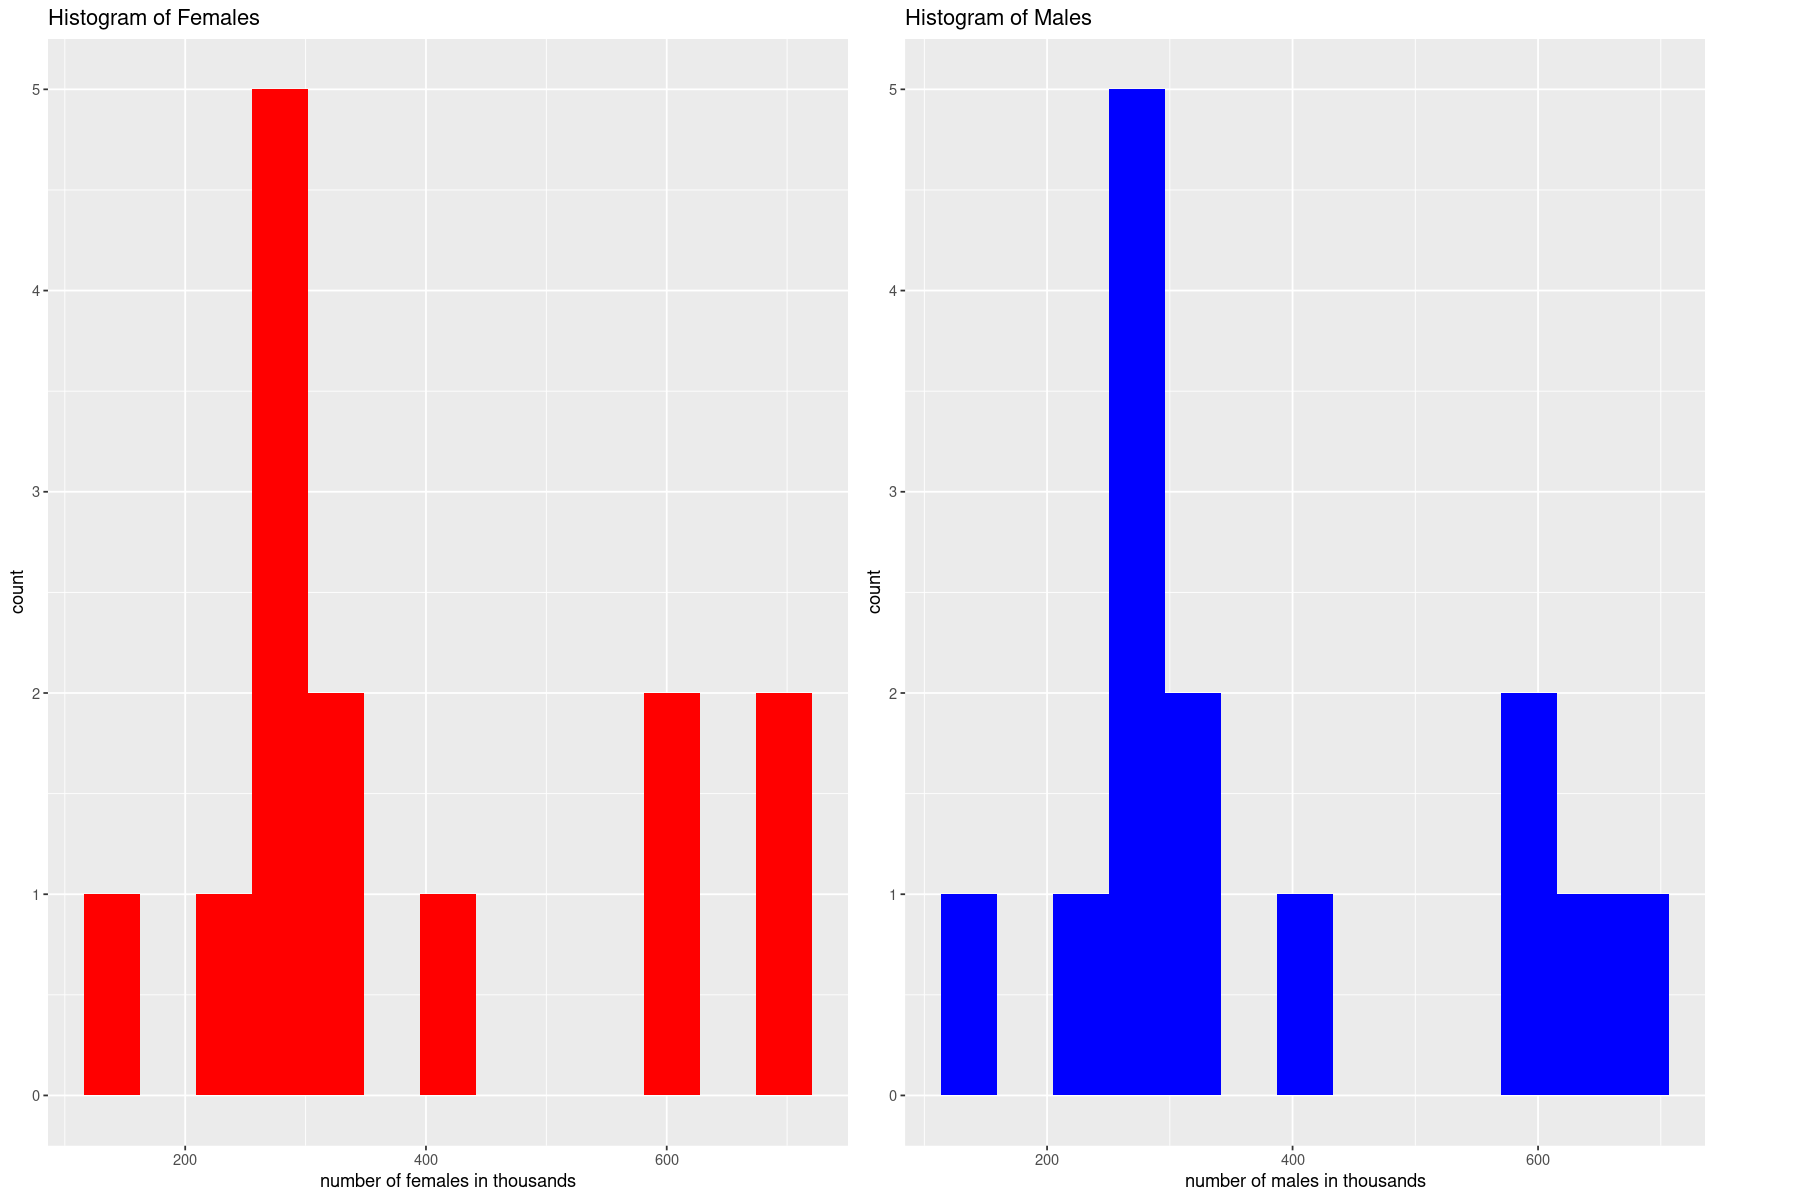

In [44]:
p1 <- ggplot(df[df$age == "TOTAL",], aes(x=females)) +
    geom_histogram(fill = "red", bins = 13) +
    scale_x_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    labs(x = "number of females in thousands", title = "Histogram of Females")
p2 <- ggplot(df[df$age == "TOTAL",], aes(x=males)) +
    geom_histogram(fill = "blue", bins = 13) +
    scale_x_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    labs(x = "number of males in thousands", title = "Histogram of Males")
pg <- plot_grid(p1 + theme(legend.position="none"), 
                p2 + theme(legend.position="none"), 
                nrow=1)

options(repr.plot.width=15, repr.plot.height=10)
plot_grid(pg, legend, rel_widths = c(2, .1))

<b>Pozorování:</b>

Vidíme, že oba histogramy jsou velmi podobné, tudíž můžeme předpokládat že pocházejí ze stejného rozdělení. Zároveň pozorujeme že jsou oba histogramy "sešikmené doprava". Sešikmenost je způsobená větším počtem krajů s počtem obyvatel okolo 300 tisíc. Pouze 4 kraje přesahují hranici 600 tisíc obyvatel (Praha, Středočeský, Moravskoslezký, Jihomoravský).

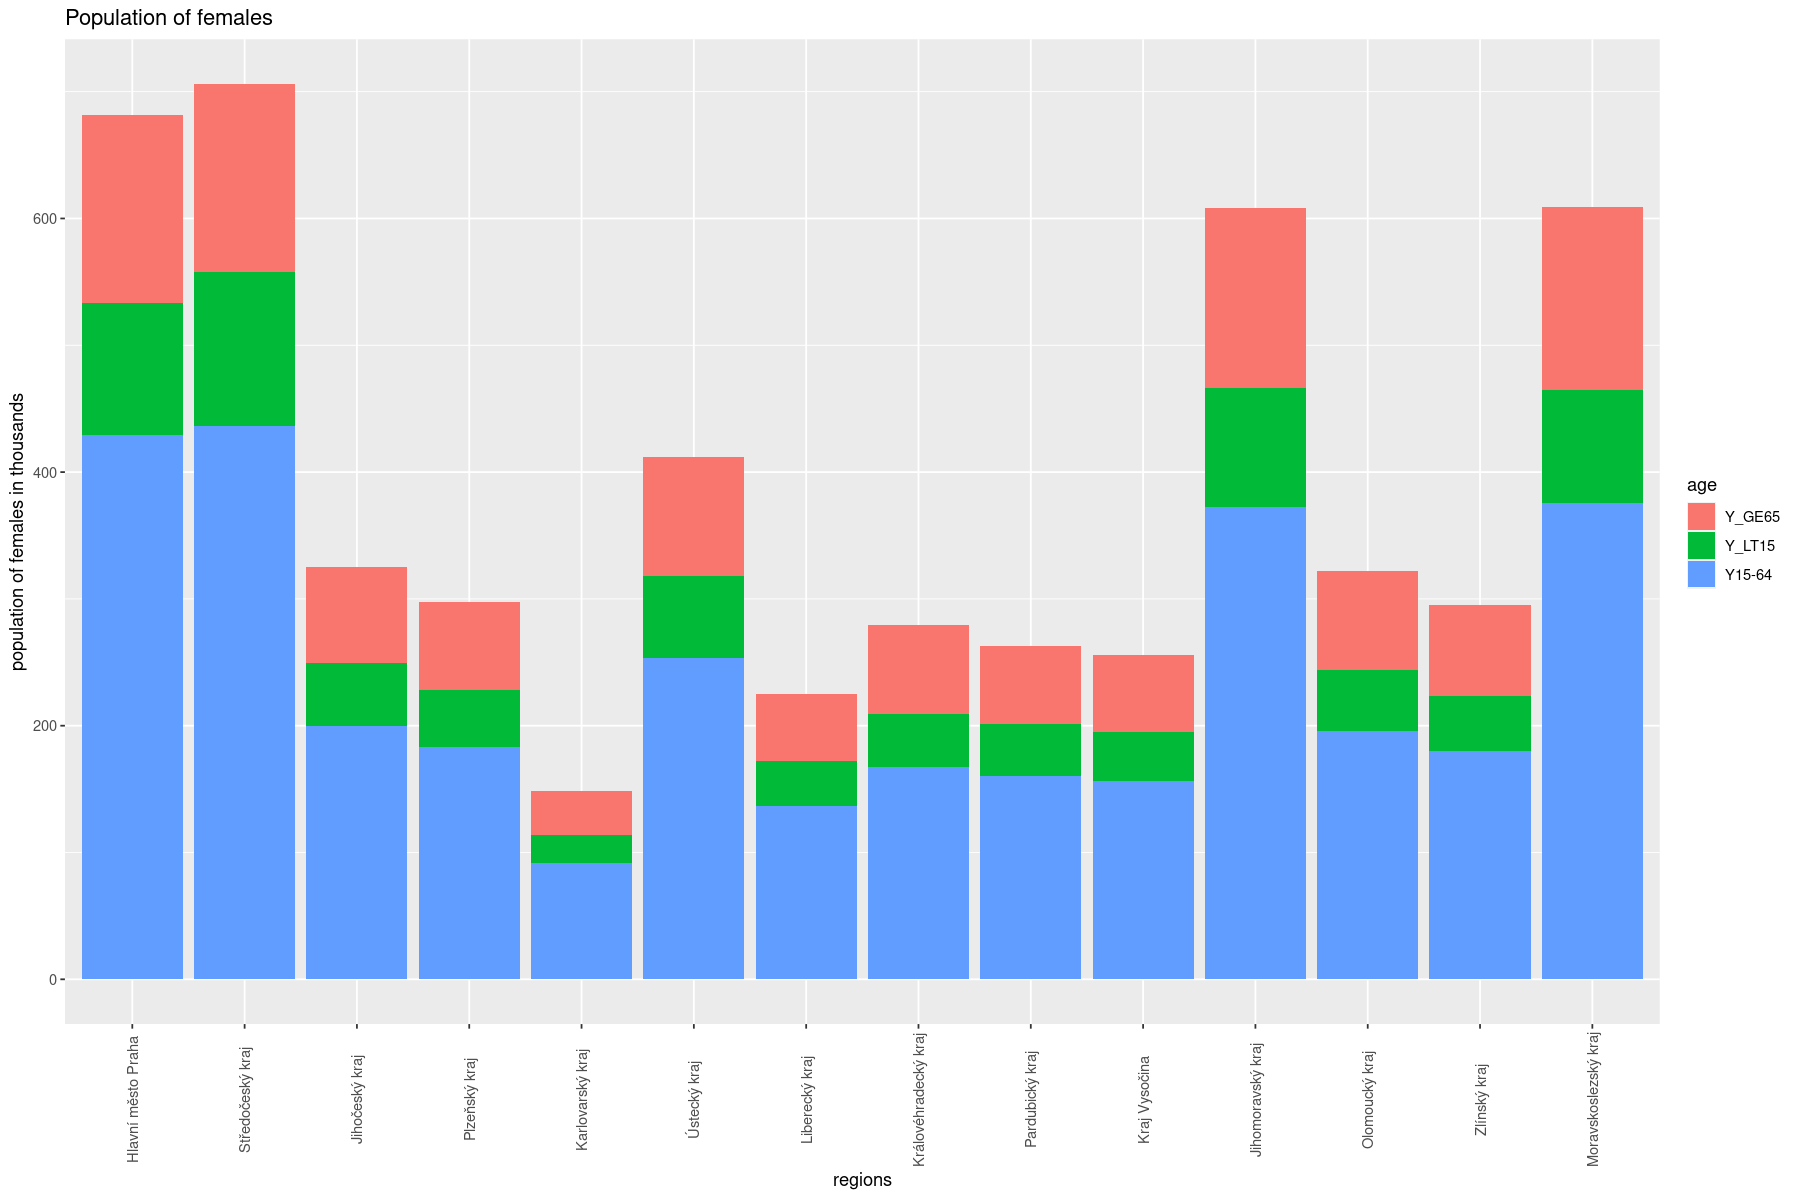

In [45]:
ggplot(dF[dF$age != "TOTAL",], aes(x = geo, y = females, fill=age)) +
  geom_bar(stat = "identity") +
    scale_y_continuous(labels = scales::comma_format(scale = 1e-3)) + 
  labs(title = "Population of females", x = "regions", y = "population of females in thousands") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

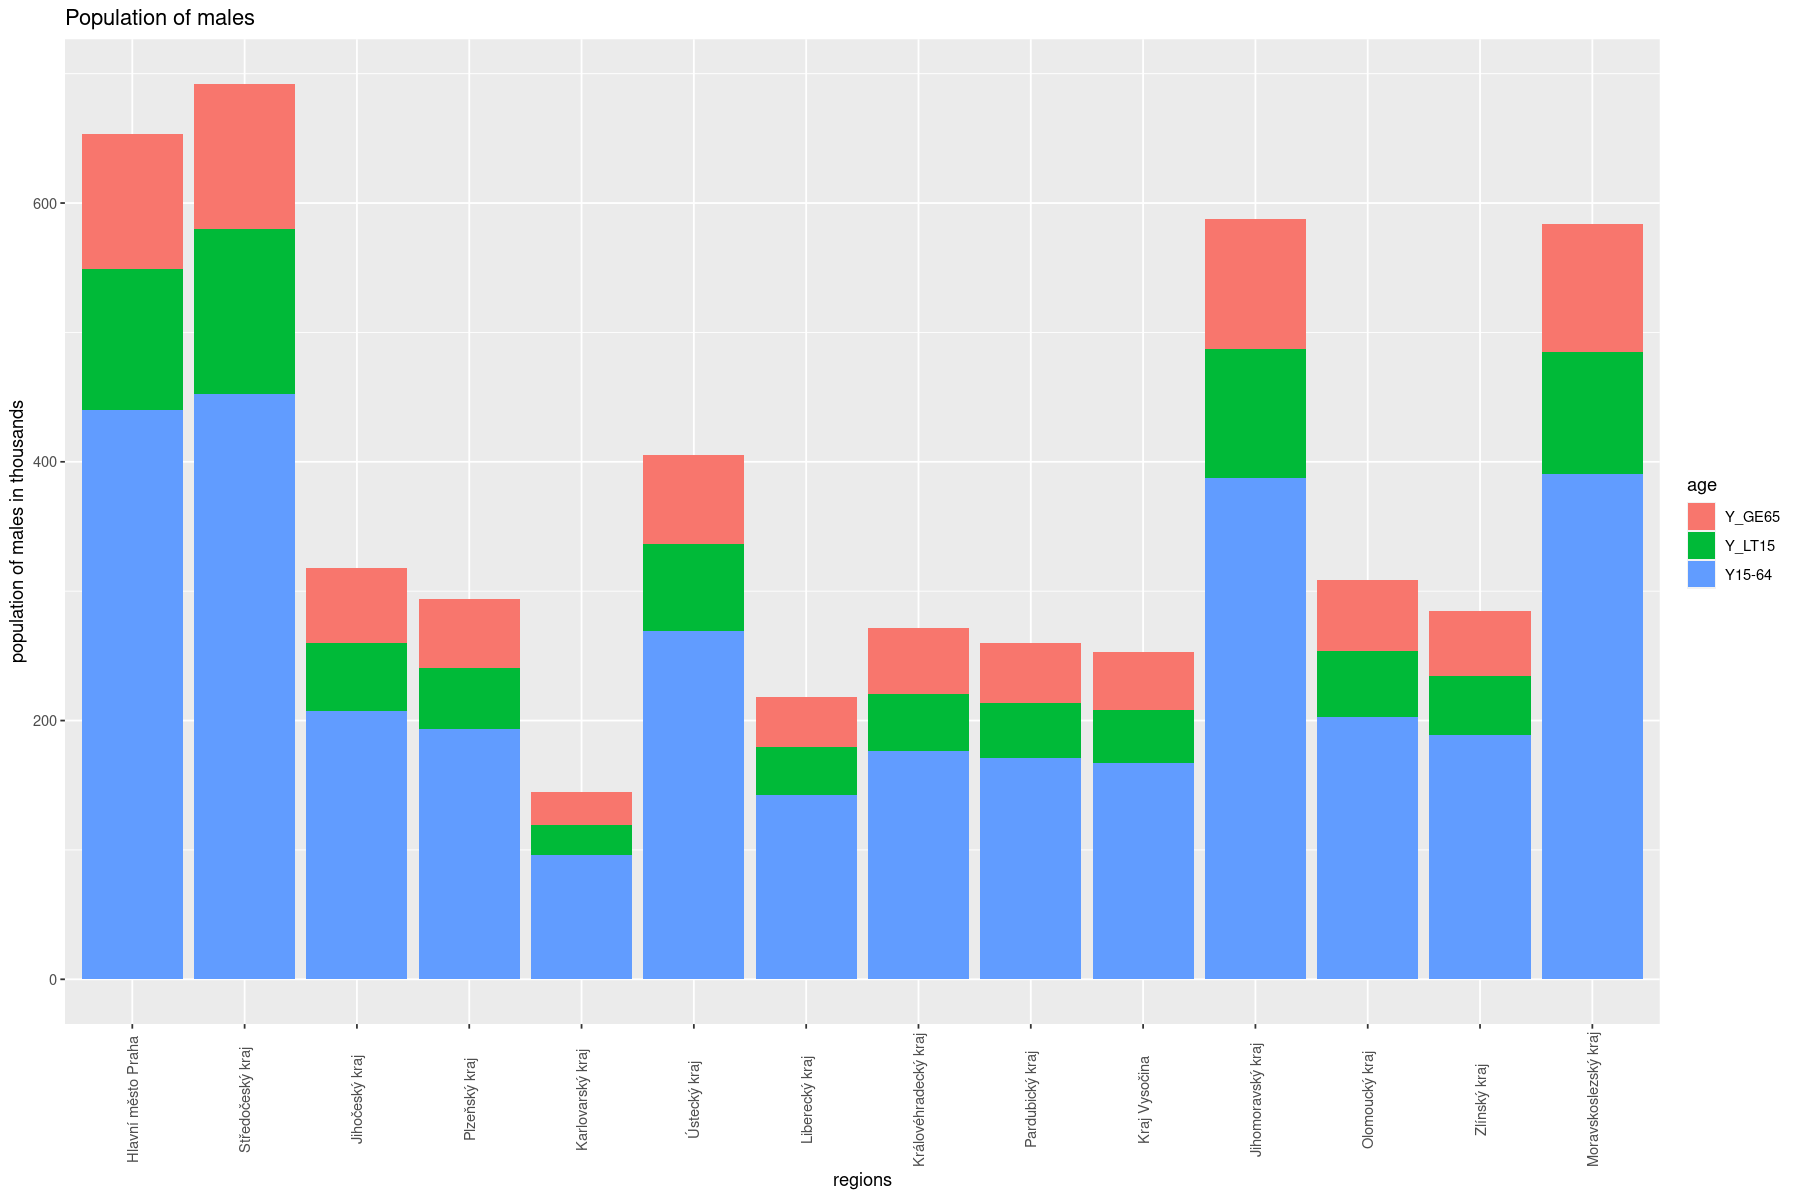

In [46]:
ggplot(dF[dF$age != "TOTAL",], aes(x = geo, y = males, fill=age)) +
  geom_bar(stat = "identity") +
    scale_y_continuous(labels = scales::comma_format(scale = 1e-3)) + 
  labs(title = "Population of males", x = "regions", y = "population of males in thousands") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

Z grafů můžeme vidět, že populace mužů a žen v jednotlivých krajích je přibližně stejná. Nejlidnatější kraj je Středočeský a nejméně obyvatel má Karlovarský kraj. Taky můžeme vidět, že největší podíl populace tvoří věková kategorie 15-64 let. V případě mužů to vypadá, že podíl mužů pod 15 let a nad 65 let je přibližně stejný. U žen nejsou tyto dvě kategorie tak vyrovnané, převažují zde ženy nad 65 let oproti ženám pod 15 let.

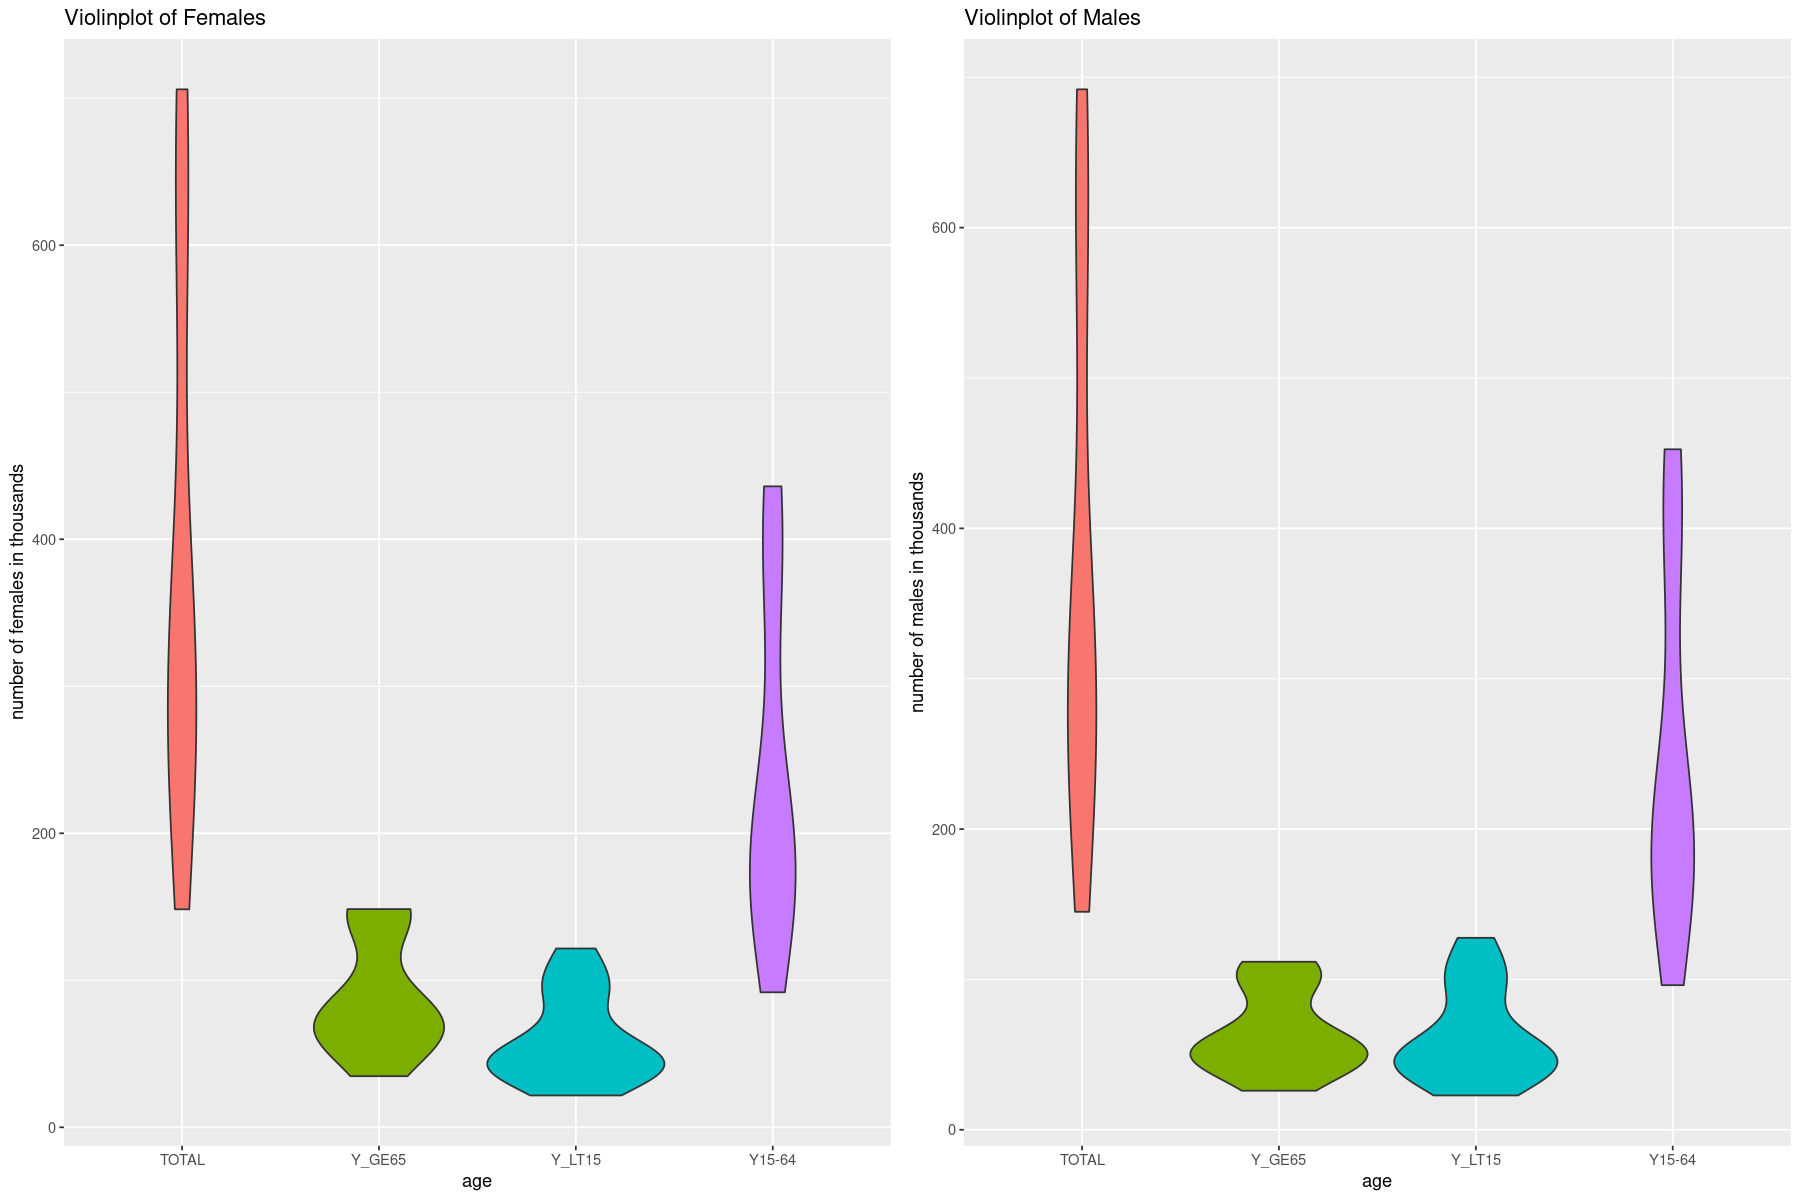

In [47]:
p1 <- ggplot(df, aes(x=age, y=females, fill=age)) +
    scale_y_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    labs(y = "number of females in thousands", title = "Violinplot of Females") +
        geom_violin(show.legend=F)
p2 <- ggplot(df, aes(x=age, y=males, fill=age)) +
    scale_y_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    labs(y = "number of males in thousands", title = "Violinplot of Males") +
        geom_violin(show.legend=F)
plot_grid(p1, p2, nrow=1)

Z grafu lze vidět, že žen nad 65 let je více jak mužů ( housle mužů jsou nižší a širší u počátku, tudíž se vetšina dat pohybuje tam), což odpovídá našemu předpokladu u statistických měr. Ostatní grafy si jsou velmi podobné.

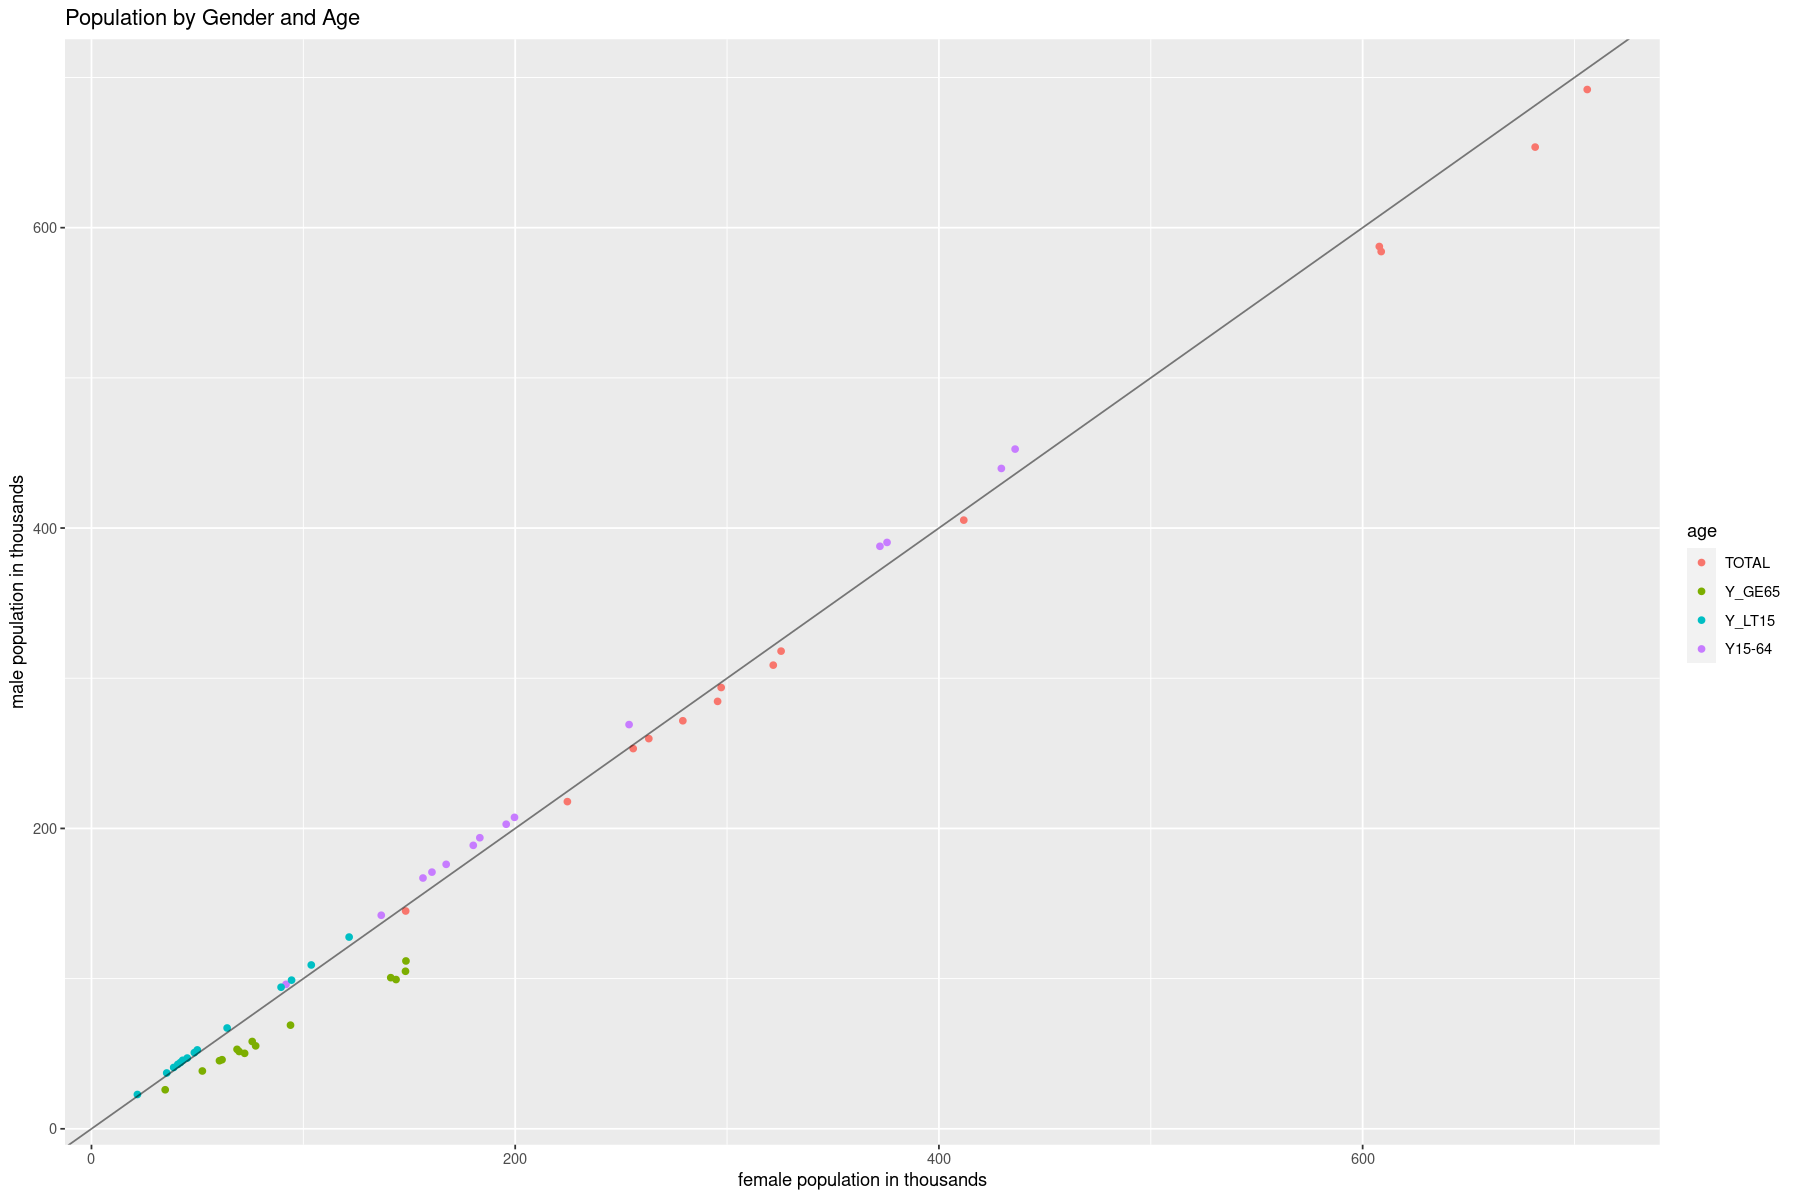

In [48]:
p <- ggplot(df, aes(x = females, y = males, color = age)) +
    scale_x_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    scale_y_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    geom_point() +
    labs(x = "female population in thousands", y = "male population in thousands", title = "Population by Gender and Age")
    p + geom_abline(intercept = 0, slope = 1, alpha=0.5)
    options(repr.plot.width=12, repr.plot.height=10)

Na podkladě grafu výše se domníváme, že rozdělení mužů a žen v jednotlivých věkových kategorií je vyrovnané, až na kategorii 65 let a více (vychýlení na stranu žen).

<h3><u>Úloha 2</u></h3>
Na základě povahy zkoumaných dat navrhněte tři dvojice (H0 a HA) potenciálně zajímavých hypotéz vedoucích na tři různé statistické testy (jiné než v úloze 3):

* Hypotézy můžete sestavovat s ohledem na konkrétní data, ale je vhodné brát i informace např. z celoevropského rámce (průměrný počet obyvatel NUTS 3 oblastí EU apod.).
* Vysvětlete, jaké testy jste vybrali a proč.
* Testy hypotéz proveďte a interpretujte jejich výsledky, jak po matematické tak po praktické stránce.

In [49]:
test.TOTAL <- df[df$age == "TOTAL",]
test.NOTTOTAL <- df[df$age != "TOTAL",]

Budeme testovat normalitu, abychom mohli případně použít navazující testy. 

<b>Je populace žen a mužů z normálního rozdělení?</b>

* nulová hypotéza: data jsou z normálního rozdělení
* alternativní hypotéza: data nejsou z normálního rozdělení

In [50]:
shapiro.test(test.TOTAL$females)


	Shapiro-Wilk normality test

data:  test.TOTAL$females
W = 0.8547, p-value = 0.02574


In [51]:
shapiro.test(test.TOTAL$males)


	Shapiro-Wilk normality test

data:  test.TOTAL$males
W = 0.86133, p-value = 0.03177


Jelikož p hodnota obou testů je menší než 0.1,  hypotézu <b>zamítáme</b> v obou případech. Důvodů, proč data nejsou z normálního rozdělení, může být více (například různé velikosti krajů, jiné ekonomické podmínky...). Pro zajímavost vykreslíme QQPLOT, kde vidíme, že hodnoty neleží na přímce.

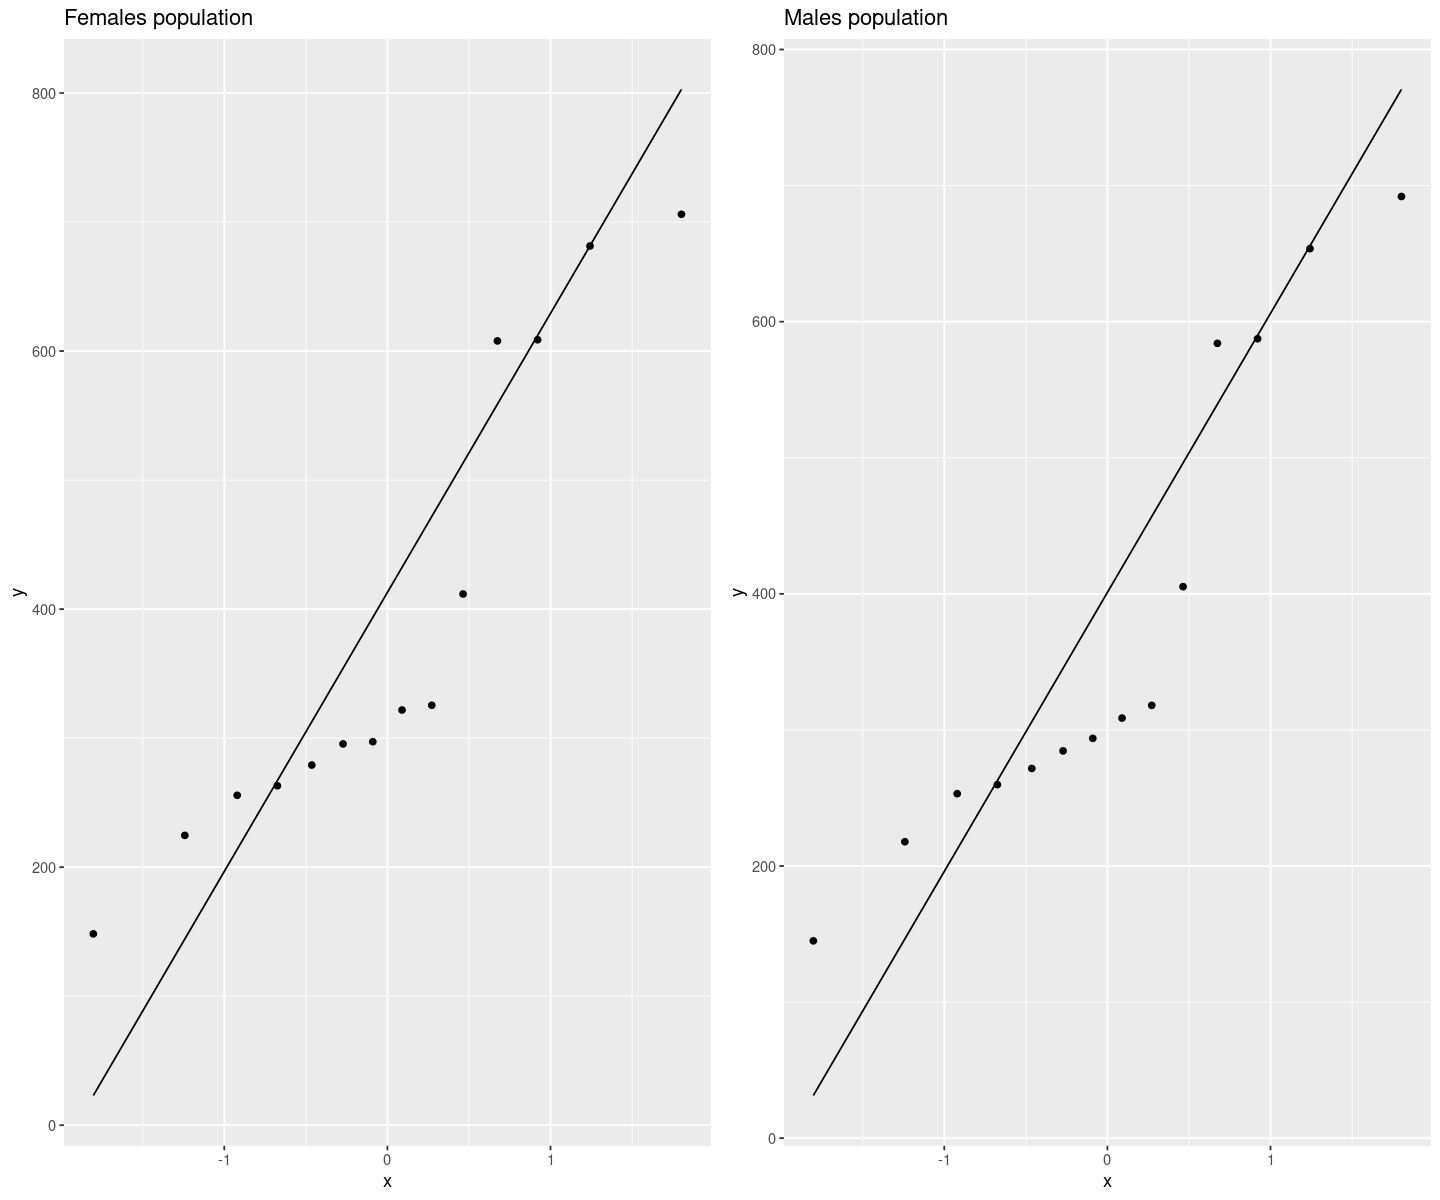

In [52]:
p1 <- ggplot(test.TOTAL, aes(sample=females)) +
        stat_qq(distribution=stats::qnorm, show.legend=T) +
    scale_y_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    labs(title = "Females population")+
        stat_qq_line(distribution=stats::qnorm, show.legend=F)
p2 <- ggplot(test.TOTAL, aes(sample=males)) +
        stat_qq(distribution=stats::qnorm, show.legend=T) +
    scale_y_continuous(labels = scales::comma_format(scale = 1e-3)) + 
    labs(title = "Males population")+
        stat_qq_line(distribution=stats::qnorm, show.legend=F)
plot_grid(p1, p2, nrow=1)

<b>Je střední hodnota počtu mužů a žen stejná?</b>

* nulová hypotéza: střední hodnota počtu mužů a žen je stejná
* alternativní hypotéza: střední hodnota počtu mužů a žen není stejná

Jelikož data nejsou z normálního rozdělení, nemůžeme použít klasický t.test. Proto jsme se rozhodli naši hypotézu testovat pomocí wilcox.test, kde není potřeba mít data z normálního rozdělení.

In [53]:
wilcox.test(test.TOTAL$males, test.TOTAL$females, conf.level= 0.95)


	Wilcoxon rank sum exact test

data:  test.TOTAL$males and test.TOTAL$females
W = 88, p-value = 0.6673
alternative hypothesis: true location shift is not equal to 0


Jelikož p hodnota je větší jak alpha (5%), hypotézu <b>nezamítáme</b>. Pokud je střední hondnota stejná, znamená to, že rozložení mužů a žen v jednotlivých krajích není signifikantně rozdílné.

<b>Změnila se střední hodnota počtu žen za posledních 10 let?</b>

* nulová hypotéza: střední hodnota se nezměnila
* alternativní hypotéza: střední hodnota se změnila

Tento test provádíme z důvodu průzkumu změn za posledních deset let. Zkoumáme, jestli se výrazně změnil počet obyvatel ženského pohlaví v České republice.

Nejprve si připravíme data z roku 2011.

In [54]:
data2011 <- data_copy[data_copy$geo %in% regiony,]
data2011 <- data2011[data2011$time == "2011-01-01",]
data2011 <- data2011[data2011$age == "TOTAL",]

In [55]:
data2011$sex <- as.factor(data2011$sex)
data2011$age <- as.factor(data2011$age)

In [56]:
females2011 <- subset(data2011, sex=="F", select=c("geo", "age", "values"))
colnames(females2011) <- c("geo", "age", "females")

In [57]:
 wilcox.test(females2011$females, test.TOTAL$females, conf.level= 0.95)


	Wilcoxon rank sum exact test

data:  females2011$females and test.TOTAL$females
W = 98, p-value = 1
alternative hypothesis: true location shift is not equal to 0


Nulovou hypotézu <b>nezamítáme</b>, jelikož p hodnota je větší jak alpha (5%). Z toho vyplývá, že se střední hodnota u žen za posledních 10 let skoro nezměnila.

<b>Liší se významně medián v různých věkových kategoriích u mužů?</b>

* nulová hypotéza: medián se liší nezanedbatelně
* alternativní hypotéza: medián se výrazně liší

Nejprve se podíváme, jestli muži z jednotlivých věkových kategorií pocházejí z normálního rozdělení. Použijeme opět shapiro.test.

In [58]:
test.Y_LT15 <- df[df$age == "Y_LT15",]
test.Y1564 <- df[df$age == "Y15-64",]
test.GE65 <- df[df$age == "Y_GE65",]

In [59]:
shapiro.test(test.Y_LT15$males)
shapiro.test(test.Y1564$males)
shapiro.test(test.GE65$males)


	Shapiro-Wilk normality test

data:  test.Y_LT15$males
W = 0.86653, p-value = 0.03751



	Shapiro-Wilk normality test

data:  test.Y1564$males
W = 0.85361, p-value = 0.02488



	Shapiro-Wilk normality test

data:  test.GE65$males
W = 0.87586, p-value = 0.05076


Vidíme, že u všech testů, kromě posledního, nulovou hypotézu <b>zamítáme</b> (p hodnota je menší než 5%). Jelikož máme dvě skupiny, u kterých nemůžeme říct, že pochází z normálního rozdělení, a jednu, u které tuto hypotézu nevyvracujeme, tak nastává problém pro výběr testu. Rozhodli jsme se tedy použít kruskal.test, který nepředpokládá normalitu a shodu rozptylu u všech dat.

In [60]:
kruskal.test(males ~ age, data = test.NOTTOTAL)


	Kruskal-Wallis rank sum test

data:  males by age
Kruskal-Wallis chi-squared = 25.721, df = 2, p-value = 2.599e-06


Nulovou hypotézu <b>zamítáme</b>, jelikož p hodnota je menší jak alpha (5%). To znamená, že jednotlivé věkové kategorie nejsou rovnoměrně zastoupeny.

<h3><u>Úloha 3</u></h3>

* Sestavte kontingenční tabulku počtů obyvatel podle pohlaví a NUTS 3 oblastí.
* Tuto tabulku interpretujte, navrhněte hypotézy o jejích vlastnostech a proveďte příslušný test.
* Interpretujte jeho výsledky.

In [61]:
kraje <- c("CZ010", "CZ020", "CZ031", "CZ032", "CZ041", "CZ042", "CZ051", "CZ052", "CZ053", "CZ063", "CZ064", "CZ071", "CZ072", "CZ080")

data_kraje <- data_copy[data_copy$geo %in% kraje,]
data_kraje <- data_kraje[data_kraje$time == "2021-01-01",]

data_kraje <- subset(data_kraje, age!="UNK")

data_kraje$sex <- as.factor(data_kraje$sex)
data_kraje$age <- as.factor(data_kraje$age)

females <- subset(data_kraje, sex=="F", select=c("geo", "age", "values"))
colnames(females) <- c("geo", "age", "females")
males <- subset(data_kraje, sex=="M", select=c("geo", "age", "values"))
colnames(males) <- c("geo", "age", "males")

data_kraje <- data_kraje[data_kraje$age != "TOTAL",]

In [62]:
contg <- data_kraje[data_kraje$sex %in% c("F", "M"),]
contg <- droplevels(contg)

In [63]:
ct <- xtabs(formula=values ~ sex + geo, data=contg)
ct

   geo
sex  CZ010  CZ020  CZ031  CZ032  CZ041  CZ042  CZ051  CZ052  CZ053  CZ063
  F 681430 706011 325503 297223 148298 411727 224629 279123 263067 255699
  M 653654 691986 318048 293818 145013 405277 217847 271680 259789 253153
   geo
sex  CZ064  CZ071  CZ072  CZ080
  F 607865 321804 295534 608761
  M 587462 308718 284585 584073

In [64]:
addmargins(ct)

,CZ010,CZ020,CZ031,CZ032,CZ041,CZ042,CZ051,CZ052,CZ053,CZ063,CZ064,CZ071,CZ072,CZ080,Sum
F,681430,706011,325503,297223,148298,411727,224629,279123,263067,255699,607865,321804,295534,608761,5426674
M,653654,691986,318048,293818,145013,405277,217847,271680,259789,253153,587462,308718,284585,584073,5275103
Sum,1335084,1397997,643551,591041,293311,817004,442476,550803,522856,508852,1195327,630522,580119,1192834,10701777


Kontingenční tabulka.

In [65]:
addmargins(prop.table(ct))

,CZ010,CZ020,CZ031,CZ032,CZ041,CZ042,CZ051,CZ052,CZ053,CZ063,CZ064,CZ071,CZ072,CZ080,Sum
F,0.06367447,0.06597138,0.03041579,0.02777324,0.01385732,0.03847277,0.02098988,0.02608193,0.02458162,0.02389313,0.05680038,0.03007015,0.02761541,0.0568841,0.5070816
M,0.06107902,0.06466085,0.02971918,0.02745507,0.01355037,0.03787007,0.02035615,0.02538644,0.02427531,0.02365523,0.05489387,0.02884736,0.02659231,0.0545772,0.4929184
Sum,0.12475349,0.13063223,0.06013497,0.05522830,0.02740769,0.07634284,0.04134603,0.05146837,0.04885693,0.04754837,0.11169425,0.05891751,0.05420773,0.1114613,1.0000000


Zde vidíme marginální pravděpodobnosti. Můžeme si povšimnout, že pro muže i ženy jsou pravděpodobnosti vždy skoro stejné.

<b>Jsou příznaky pohlaví a region nezávislé?</b>

* nulová hypotéza: pohlaví a region jsou nezávislé
* alternativní hypotéza: pohlaví a region nejsou nezávislé

In [66]:
chisq.test(ct)


	Pearson's Chi-squared test

data:  ct
X-squared = 340.88, df = 13, p-value < 2.2e-16


Nulovou hypotézu <b>zamítáme</b> ve prospěch alternativní. Tento výsledek si vysvětlujeme tak, že pokud budeme mít v určitém kraji konkrétní hodnotu počtu mužů, můžeme očekávat podobný počet žen. 


<b>Tvoří muži 50% populace v každém regionu?</b>

* nulová hypotéza: Podíl mužů v každém regionu se pohybuje kolem 50%.
* alternativní hypotéza: Podíl mužů v každém regionu je signifikantně rozdílný od 50%

Zkusíme tedy otestovat naší myšlenku z minulého testu, že můžeme v každém kraji očekávat podobný počet žen a mužů.

Pro test hypotézy využijeme prop.test, který vyžaduje nezávislé stejně rozdělené náhodné veličiny. To splňujeme.

In [76]:
dt <- df[df$age == "TOTAL",]
prop <- dt$males / (dt$males + dt$females)

In [79]:
prop.test(x = prop, n = rep(1, nrow(dt)), p = rep(0.5, nrow(dt)))

Warning message in prop.test(x = prop, n = rep(1, nrow(dt)), p = rep(0.5, nrow(dt))):
“Chi-squared approximation may be incorrect”



	14-sample test for given proportions without continuity correction

data:  prop out of rep(1, nrow(dt)), null probabilities rep(0.5, nrow(dt))
X-squared = 0.0028772, df = 14, p-value = 1
alternative hypothesis: two.sided
null values:
 prop 1  prop 2  prop 3  prop 4  prop 5  prop 6  prop 7  prop 8  prop 9 prop 10 
    0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5 
prop 11 prop 12 prop 13 prop 14 
    0.5     0.5     0.5     0.5 
sample estimates:
   prop 1    prop 2    prop 3    prop 4    prop 5    prop 6    prop 7    prop 8 
0.4895977 0.4949839 0.4942079 0.4971195 0.4944001 0.4960527 0.4923363 0.4932435 
   prop 9   prop 10   prop 11   prop 12   prop 13   prop 14 
0.4968653 0.4974983 0.4914655 0.4896229 0.4905631 0.4896515 


Z výsledků p-hodnot nulovou hypotézu <b>nezamítáme</b>. Z kontingenční tabulky lze vidět, že rozdíl mužů a žen není signifikantně velký. 